# Iteration 0: Cell to cell type assignment. Cell label = 1896

In [ ]:
# Uncomment the line below to show all rows in a pandas dataframe
# import pandas as pd
# pd.set_option('display.max_rows', None)

### This is a notebook demonstrating what happens under the hood in the cell to cell type step in pciSeq



The focus here is on a particular cell (with label 1896) that has 27 gene counts but inside the first iteration the most likely class is the Zero class

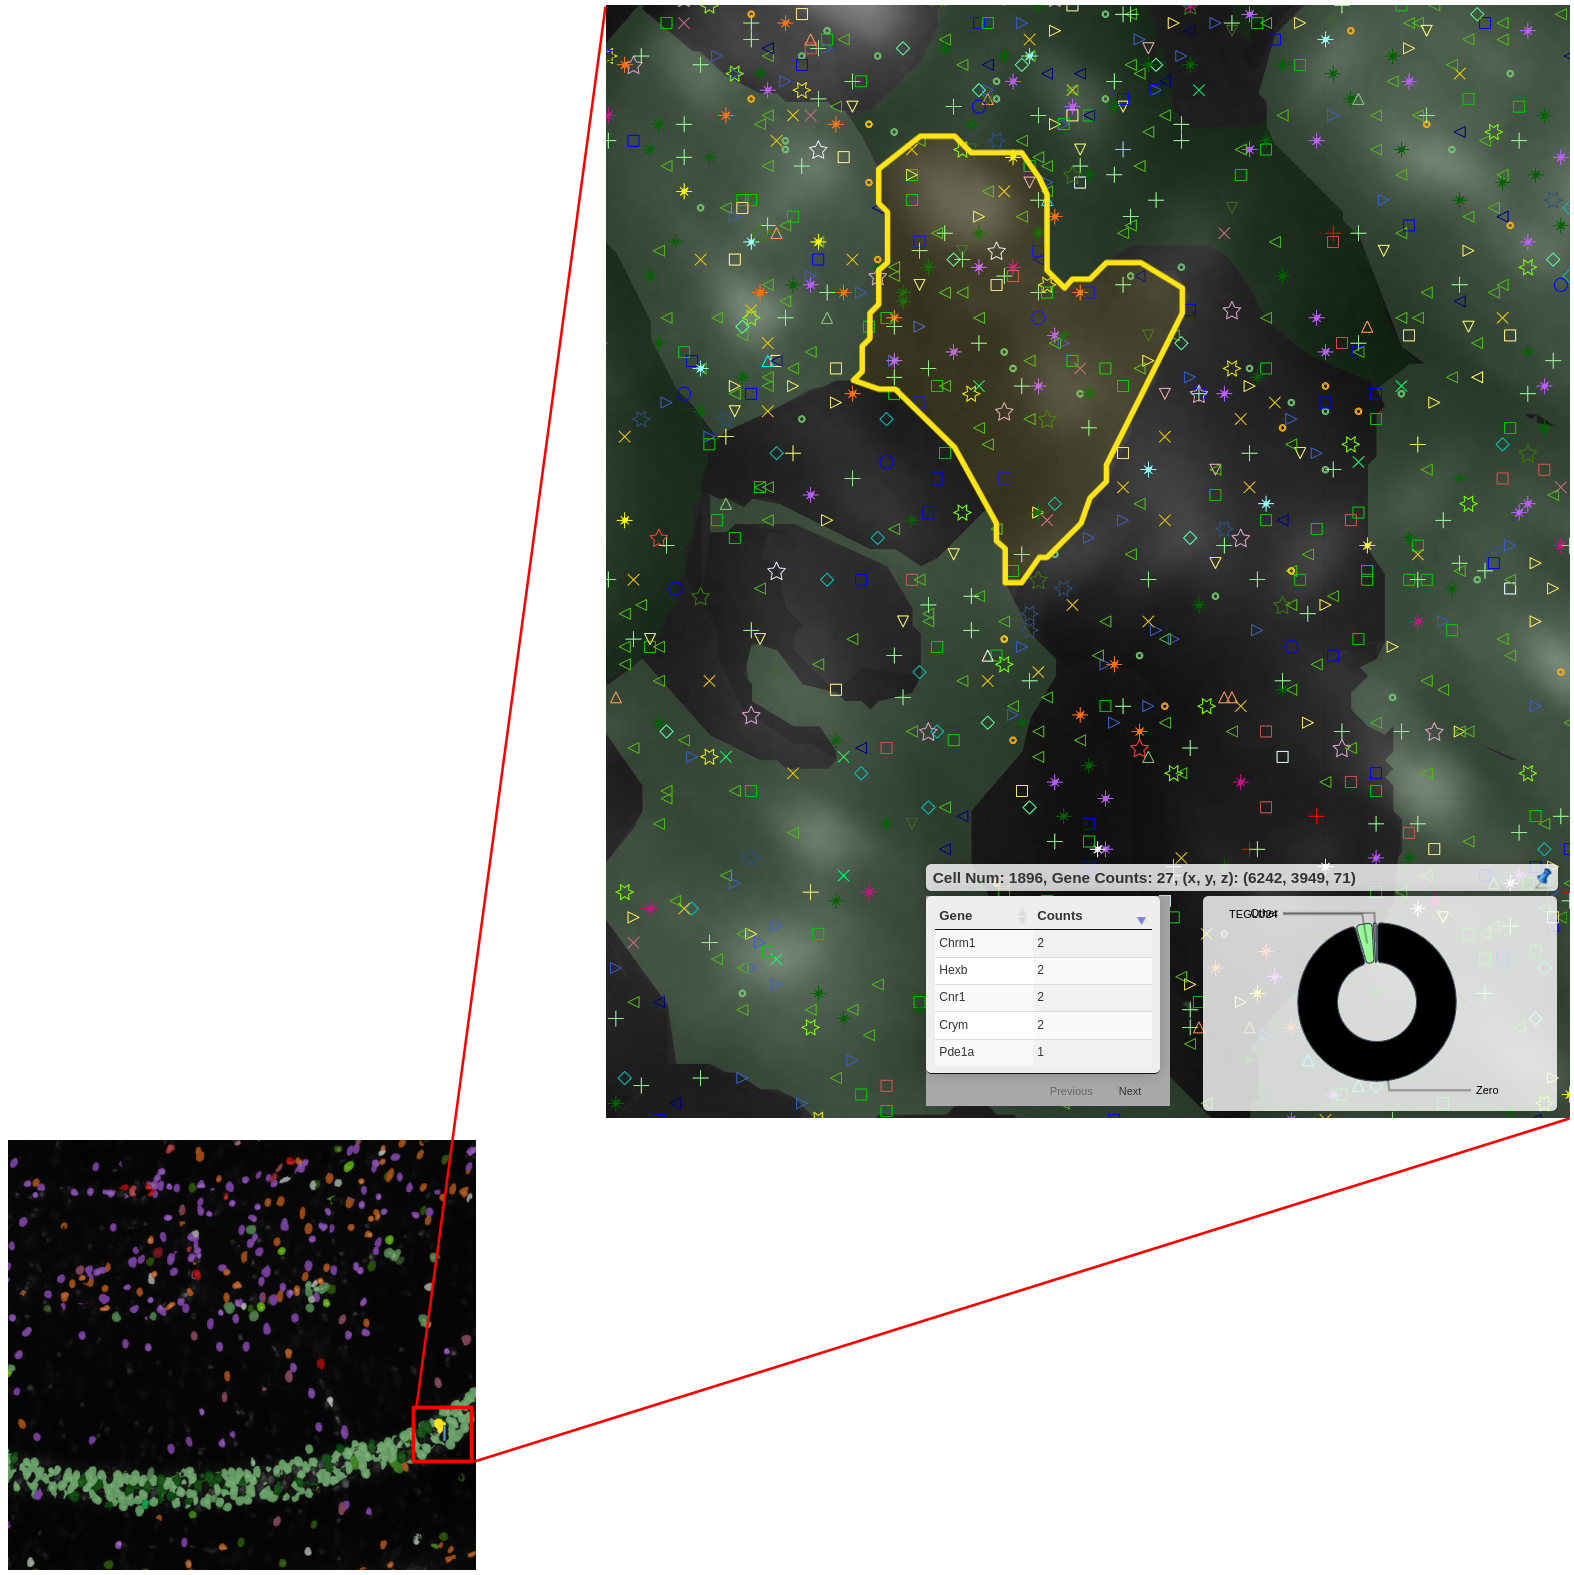

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy.special import softmax
import gdown

In [3]:
!pip install git+https://github.com/acycliq/pciSeq.git@dev_3d
import pciSeq

  Cloning https://github.com/acycliq/pciSeq.git (to revision dev_3d) to /tmp/pip-req-build-yf_q3pmy
  Running command git clone --filter=blob:none --quiet https://github.com/acycliq/pciSeq.git /tmp/pip-req-build-yf_q3pmy
  Running command git checkout -b dev_3d --track origin/dev_3d
  Switched to a new branch 'dev_3d'
  Branch 'dev_3d' set up to track remote branch 'dev_3d' from 'origin'.
  Resolved https://github.com/acycliq/pciSeq.git to commit 31fd7688f1f848d9e59931636ce39479614ea23d
  Preparing metadata (setup.py) ... done


In [4]:
file_id = "1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
output = "pciSeq.pickle"

In [5]:
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M
From (redirected): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M&confirm=t&uuid=1fc2f7be-bb12-4f19-8eee-9357de8fdb9e
To: /tmp/pciSeq/data/pciSeq.pickle
100%|██████████████████████████████████████| 1.79G/1.79G [03:46<00:00, 7.89MB/s]


'pciSeq.pickle'

In [6]:
obj = pd.read_pickle(output)

In [7]:
my_cell = 1896
my_classes = ['TEGLU23', 'TEGLU24', 'TEGLU21', 'DGGRC2', 'DGGRC1', 'Zero']

In [8]:
# Set the hyperparameters
rSpot = 2.0               # Spread of the negative binomial
SpotReg = 0.1             # Spot regularization: Additive factor applied to the single cell data
inefficiency = 0.2        # multiplicative factor applied to the single cell data

In [9]:
# Another piece of information comes from the single cell data. For simplicity
# we are pulling here only the gene expressions for 'TEGLU23' (expected in CA3) 
# and 'TEGLU24', 'TEGLU21' (expected in CA3) 
my_class_definitions = obj.single_cell.mean_expression[my_classes]
my_class_definitions

class_name,TEGLU23,TEGLU24,TEGLU21,DGGRC2,DGGRC1,Zero
gene_name,,,,,,
Abi3bp,0.000000,0.006382,0.009615,0.000295,0.000000,0.0
Acly,0.247934,0.133039,0.519231,0.082422,0.110885,0.0
Adcyap1,0.138430,0.004418,0.221154,0.000591,0.001017,0.0
Adora2a,0.002066,0.001473,0.000000,0.000000,0.002035,0.0
Afp,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...
Vtn,0.004132,0.006382,0.000000,0.002954,0.000000,0.0
Wfs1,0.179752,1.669121,0.163462,0.027179,0.010173,0.0
Yjefn3,0.101240,0.110457,0.076923,0.095716,0.064090,0.0


### Part 1. Initialization

In [10]:
# To set the initial gene counts for any given cell we collect the gene reads inside the cell boundaries
# For cell 10275 these gene reads are the spots below
spots_1896 = obj.spots.data[obj.spots.data.label == my_cell]
spots_1896.sort_values(by=['gene_name', 'x', 'y', 'z'])

,x,y,z,plane_id,label,gene_name,score
spot_id,,,,,,,
75331,6241.880859,3949.592529,100.719444,31,1896,Apoe,0.8438
76760,6229.880859,3951.592529,62.148018,19,1896,Aqp4,0.4243
77456,6241.880859,3969.592529,94.290878,29,1896,Arc,0.5920
81382,6215.880859,3953.592529,91.076591,28,1896,C1ql3,0.3018
132413,6239.880859,3947.592529,107.148026,33,1896,Ccn3,0.3420
85878,6218.880859,3944.592529,97.505157,30,1896,Chrm1,0.8420
85869,6240.880859,3931.592529,78.219444,24,1896,Chrm1,0.3254
87312,6242.880859,3950.592529,91.076591,28,1896,Chrnb2,0.4043
88304,6236.880859,3953.592529,91.076591,28,1896,Cnr1,0.4660


In [11]:
# Hence we aggregate per gene and we derive the gene counts
cgc = spots_1896.groupby('gene_name').size()
cgc

gene_name
Apoe         1
Aqp4         1
Arc          1
C1ql3        1
Ccn3         1
Chrm1        2
Chrnb2       1
Cnr1         2
Crym         2
Ctss         1
Cx3cr1       1
Etv1         1
Gfap         1
Hexb         2
Itgam        1
Npnt         1
Nrgn         1
Nrn1         1
Pde1a        1
Rims4        1
Serpine2     1
Tnfaip8l3    1
Wfs1         1
dtype: int64

In [12]:
# the cell has 27 reads inside its boundaries
cgc.sum()

27

In [13]:
# The cell gene counts introduced above contain only genes with gene reads > 0.
# We need however the full gene panel
cgc = cgc.reindex(obj.genes.gene_panel, fill_value=0)

In [14]:
# Note also that the eta (the random variable to model the gene inefficiency) is initialied as a vector of ones with lenght
# equal to the number of genes:
eta_bar = np.ones(obj.nG)

### Part 2. Cell to cell type

In [15]:
def negative_binomial_loglikelihood(x: np.ndarray, r: float, p: np.ndarray) -> np.ndarray:
    log_likelihood = x * np.log(p) + r * np.log(1 - p)

    return log_likelihood

In [16]:
# prepare now the data from the negative binomial
ScaledExp = my_class_definitions * inefficiency * eta_bar[:, None]
ScaledExp = ScaledExp + SpotReg
p = ScaledExp / (ScaledExp + rSpot)

In [17]:
# evaluate the loglikelihood
class_contr = negative_binomial_loglikelihood(cgc.values[:, None], rSpot, p.values)
class_contr.sum(axis=0)

array([-120.92894383, -112.04321693, -121.31591684, -113.85030699,
       -114.60449585, -112.84232892])

In [18]:
# some housekeeping, results look better in a dataframe
class_contr_df = pd.DataFrame(class_contr, columns=my_classes).set_index(obj.genes.gene_panel)
class_contr_df

,TEGLU23,TEGLU24,TEGLU21,DGGRC2,DGGRC1,Zero
Abi3bp,-0.097580,-0.098796,-0.099411,-0.097637,-0.097580,-0.097580
Acly,-0.144257,-0.122762,-0.194114,-0.113219,-0.118591,-0.097580
Adcyap1,-0.123776,-0.098422,-0.139267,-0.097693,-0.097774,-0.097580
Adora2a,-0.097974,-0.097861,-0.097580,-0.097580,-0.097968,-0.097580
Afp,-0.097580,-0.097580,-0.097580,-0.097580,-0.097580,-0.097580
...,...,...,...,...,...,...
Vtn,-0.098367,-0.098796,-0.097580,-0.098143,-0.097580,-0.097580
Wfs1,-2.885906,-2.117213,-2.905583,-3.096927,-3.124866,-3.142103
Yjefn3,-0.116772,-0.118510,-0.112179,-0.115729,-0.109751,-0.097580
Zcchc12,-0.135395,-0.107002,-0.101240,-0.107348,-0.112253,-0.097580


In [19]:
# Get the total loglikelihood
class_contr_df.sum(axis=0).sort_values(ascending=False)

TEGLU24   -112.043217
Zero      -112.842329
DGGRC2    -113.850307
DGGRC1    -114.604496
TEGLU23   -120.928944
TEGLU21   -121.315917
dtype: float64

I seems that the TEGLU24 class has the highest loglikelihood. However the cell was given the Zero type as the most likely one. 

Lets look at the prior then.

In [23]:
log_prior = pd.DataFrame(obj.cellTypes.log_prior).set_index(obj.cells.class_names)
log_prior = log_prior.loc[my_classes]
log_prior

,0
TEGLU23,-4.804021
TEGLU24,-4.804021
TEGLU21,-4.804021
DGGRC2,-4.804021
DGGRC1,-4.804021
Zero,-0.693147


In [24]:
class_total_df = class_contr_df.sum(axis=0) + log_prior.squeeze()
class_total_df.sort_values(ascending=False)

Zero      -113.535476
TEGLU24   -116.847238
DGGRC2    -118.654328
DGGRC1    -119.408517
TEGLU23   -125.732965
TEGLU21   -126.119938
dtype: float64

While the negative binomial yields the THEGLU24 cell type as the most likely class when we combine the prior, results get shifted and Zero class comes on top